In [35]:
from unbinned_lkl import (
    plot_counts_in_energy,
    previous_limits,
    FigSetup,
    compute_ALP_absorption,
    DifferentialCounts,
    GridLikelihood
    )


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=20)
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=25)

from functools import partial
from scipy.stats import chi2
import numpy as np
import astropy.units as u
from pathlib import Path
import scipy.integrate as integrate
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from astropy.table import Table

###########__________________________##############

from gammapy.modeling import Fit
import gammapy.irf as irf
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.utils.random import get_random_state
 
    
    
    ####-----------------------------------###
    
    
    
# models modules
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    TemplateSpatialModel,
    FoVBackgroundModel,
    SpectralModel,
    Parameter, 
    TemplateSpectralModel
)
# dataset modules
from gammapy.datasets import (
    MapDataset, 
    MapDatasetOnOff, 
    MapDatasetEventSampler,
    SpectrumDatasetOnOff,
    SpectrumDataset, 
    Datasets
)
from gammapy.maps import MapAxis, WcsGeom, Map, MapCoord
from gammapy.makers import MapDatasetMaker, SpectrumDatasetMaker





from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer

In [36]:
def compute_unbinned_likelihood(x, dnde,**kwargs):
    s     = dnde.signal_edisp
    marks = dnde.get_dnde(x,estimated=True)

    return -s  + np.sum(np.log(marks))

In [37]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from ebltable.tau_from_model import OptDepth
from astropy import constants as c

%matplotlib inline

In [38]:
m, g = 1.,1.
alp = ALP(m,g)

In [39]:
ngc1275 = Source(z = 0.017559, ra = '03h19m48.1s', dec = '+41d30m42s')
print (ngc1275.z)
print (ngc1275.ra, ngc1275.dec)
print (ngc1275.l, ngc1275.b)


0.017559
49.950416666666655 41.51166666666666
150.57567432060083 -13.26134354429635


In [40]:

EGeV = np.logspace(1.,3.5,250)

In [41]:

pin = np.diag((1.,1.,0.)) * 0.5

In [42]:
m = ModuleList(alp, ngc1275, pin = pin, EGeV = EGeV)
m.alp.m = 30.
m.alp.g = 0.5

In [43]:
m.add_propagation("ICMGaussTurb", 
                  0, # position of module counted from the source. 
                  nsim = 10, # number of random B-field realizations
                  B0 = 10.,  # rms of B field
                  n0 = 39.,  # normalization of electron density
                  n2 = 4.05, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                  r_abell = 500., # extension of the cluster
                  r_core = 80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                  r_core2 = 280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta = 1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2= 0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta = 0.5, # scaling of B-field with electron denstiy
                  kL = 0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012 
                  kH = 9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q = -2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=0 # random seed for reproducability, set to None for random seed.
                 )
m.add_propagation("EBL",1, model = 'dominguez') # EBL attenuation comes second, after beam has left cluster
m.add_propagation("GMF",2, model = 'jansson12', model_sum = 'ASS') # finally, the beam enters the Milky Way Field

environs.py: 431 --- INFO: Using inputted chi
environs.py:1039 --- INFO: Using inputted chi


In [44]:
px,py,pa = m.run(multiprocess=2)

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 644 --- INFO: Running Module 2: <class 'gammaALPs.base.environs.MixGMF'>


(10, 250)
0.4926360378536917
0.6594845729548637


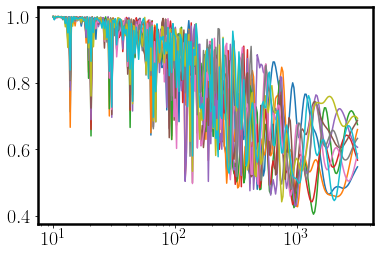

In [45]:
pgg = px + py # the total photon survival probability

print (pgg.shape)
print (np.min(np.median(pgg, axis = 0)))
print (np.min(np.max(pgg, axis = 0)))
effect = dict(path_effects=[withStroke(foreground="w", linewidth=2)])

for p in pgg: # plot all realizations
    plt.semilogx(m.EGeV, p)

#plt.xlabel('Energy (GeV)')
#plt.ylabel('Photon survival probability')
#plt.legend(loc = 0, fontsize = 'medium')
#
#plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}} = {1:.1f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(m.alp.m,m.alp.g),
#             xy = (0.95,0.1), size = 'x-large', xycoords = 'axes fraction', ha = 'right',**effect)
#
#plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
#plt.subplots_adjust(left = 0.2)
#plt.savefig("pgg.png", dpi = 150)
